# Cluster Analysis

## Import Nessasery Libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools as itl
import copy

## Define Statistic Methods

In [4]:
class StatsFuncs(object):    

    @staticmethod
    def normal(size, mean=0, var=1):
        """
        shape: numpy arrays, shape of the outut
        mean:  float mean of the normal distribution
        var: vatriance of the normal distribution
        """
        return np.random.normal(mean, var, size)

    @staticmethod
    def multivariate_normal(*args, **kwargs):
        """
        alias of numpy.random.multivariate_normal
        """
        return np.random.multivariate_normal(*args, **kwargs)
    
    @staticmethod
    def uniform(*args, **kwargs):
        """
        alias function of numpy.random.uniform
        """
        return np.random.uniform(*args, **kwargs)
            
    @staticmethod
    def choice(*args, **kwargs):
        """
        alias function of numpy.random.choice
        return: a list of all choosen numbers
        """
        return np.random.choice(*args, **kwargs)

## Generate Dataset

In [5]:
class Datasets(object):
    def __init__(self, cluster_num = 7):
        stats = StatsFuncs()
        size = 1000
        self.cluster_num = cluster_num
        self.data = np.array([])
        
        
        for i in xrange(self.cluster_num):
            cluster_means = np.array([stats.choice(16), stats.choice(16)])
            cluster_vars = np.array([[stats.choice([1, 2]), 0], 
                                      [0, stats.choice([1, 2])]])
            if i == 0:
                self.data = stats.multivariate_normal(cluster_means,
                                                      cluster_vars,
                                                      size)
            else:    
                self.data = np.vstack((self.data, stats.multivariate_normal(cluster_means,
                                                                            cluster_vars,
                                                                            size)))

### What does data look like 

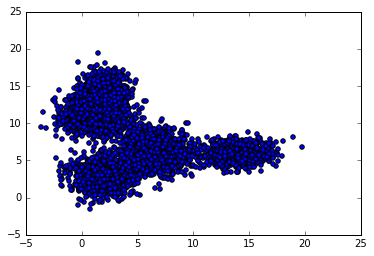

In [6]:
dataset = Datasets()
plt.scatter(dataset.data[:, 0], dataset.data[:, 1])
plt.show()

## Define KMeans Class

In [7]:
class KM(object):
    def __init__(self):
        self.type = type
        self.dataset = Datasets()
        self.data = self.dataset.data
        
        self.stats = StatsFuncs()

    def dist(self, c, data):
        """
        calculate distances between points x and y
        """
        dist = np.sqrt(((data - c) ** 2).sum(axis = 1))
        return dist

    def lloyd_routine(self, centers):
        """
        repeat routine mentioned in lloyd's algorithm
        """
        if self.type == "kmedoids":
            new_dist = 0
            old_dist = 0
            while new_dist >= old_dist:
                # get distances from different centers
                center_dists = np.array([self.dist(center, self.data) for center in centers])

                # get labels for all points
                labels =  [reduce(np.logical_and, [center_dists[j] <= center_dists[i] for i in xrange(len(center_dists))])
                           for j in xrange(len(center_dists))]

                # get total distances from closest center
                total_dists = np.zeros(center_dists[0].shape)
                for i, label in enumerate(labels):
                    total_dists[label] = center_dists[i][label]
                old_dist = total_dists.sum()

                
                # randomly select another center
                new_centers = copy.deepcopy(centers)
                new_centers[self.stats.choice(len(new_centers), 1)] = self.dataset.data[self.stats.choice(self.dataset.data.shape[0], 
                                                                                                  1), :]
                # get new distances from different centers
                center_dists = np.array([self.dist(center, self.data) for center in new_centers])

                # get new labels for all points
                labels =  [reduce(np.logical_and, [center_dists[j] <= center_dists[i] for i in xrange(len(center_dists))])
                           for j in xrange(len(center_dists))]

                # get total distances from closest center
                total_dists = np.zeros(center_dists[0].shape)
                for i, label in enumerate(labels):
                    total_dists[label] = center_dists[i][label]
                new_dist = total_dists.sum()
            centers = new_centers   
        else:
            # get distances from different centers
            center_dists = np.array([self.dist(center, self.data) for center in centers])


            # get labels of all points (label point with the number of the closest center )
            labels =  [reduce(np.logical_and, [center_dists[j] <= center_dists[i] for i in xrange(len(center_dists))])
                       for j in xrange(len(center_dists))]

            # get total distance of all points from their own closest center
            total_dists = np.zeros(center_dists[0].shape)
            for i, label in enumerate(labels):
                total_dists[label] = center_dists[i][label]

            # update location of centers
            if self.type == "kmedians":
                centers = [np.median(self.data[label], axis=0) for label in labels]
            else:
                centers = [np.mean(self.data[label], axis=0) for label in labels]
        
        return centers, total_dists.sum()
        
            
    def kmeans(self, type="vanilla"):
        self.type = type
        assert self.type in ['vanilla', 'kmeans++', 'kmedians', 'kmedoids'], "type of kmeans should be one of 'vanilla', 'kmeans++', 'kmedians', 'kmedoids'"
            
        if self.type == 'kmeans++':
            centers = []
            choices = range(self.dataset.data.shape[0])
            N = len(choices)
            probs = [1.0/N] * N
            for i in xrange(self.dataset.cluster_num):
                
                # get a new center
                n = self.stats.choice(choices,1, probs)[0]
                c = self.dataset.data[n, :]
                centers.append(c)
                
                # get distances from different centers
                center_dists = np.array([self.dist(center, self.data) for center in centers])
                
                # get labels for all points (label of which cluster does it belong to)
                labels =  [reduce(np.logical_and, [center_dists[j] <= center_dists[i] for i in xrange(len(center_dists))])
                           for j in xrange(len(center_dists))]
                
                # get distances of all points to the nearest center
                kmeanspp_dists = np.zeros(center_dists[0].shape)
                
                for i, label in enumerate(labels):
                    kmeanspp_dists[label] = center_dists[i][label]
                
                # calculate new probabilities
                probs = (kmeanspp_dists**2 / (kmeanspp_dists**2).sum()).tolist()
                
            centers = np.array(centers)
                                  
        else: 
            centers = self.dataset.data[self.stats.choice(self.dataset.data.shape[0], 
                                               self.dataset.cluster_num, replace=False), :]

        traces = [centers]
        dists = []
        
        # calculate the distance between centers and all points
        for i in xrange(20):
            centers, dist = self.lloyd_routine(centers)
            traces.append(centers)
            dists.append(dist)
        
        return np.array(traces), np.array(dists)
    

### Run Vallina KMeans Algorithm

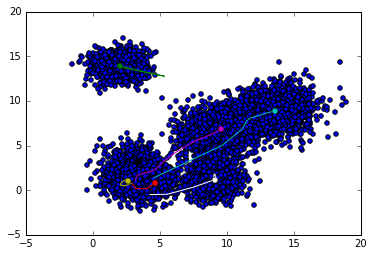

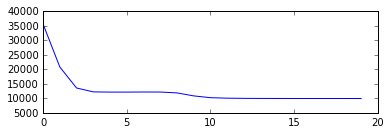

In [8]:

kmeans = KM() 
traces, dists = kmeans.kmeans()

fig = plt.figure()
centers_trace = fig.add_subplot(111)
centers_trace.scatter(kmeans.dataset.data[:, 0], kmeans.dataset.data[:, 1])

cycol = itl.cycle('grcmykw').next

assert kmeans.dataset.cluster_num < 8, 'number of color is not enough for number of clusters'

for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[:, i, 0], traces[:, i, 1], cycol()) 

cycol = itl.cycle('grcmykw').next
for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[-1, i, 0], traces[-1, i, 1], cycol() + 'o') 

fig = plt.figure()
dists_trace = fig.add_subplot(212)
dists_trace.plot(dists)
plt.show()

### Run KMedians

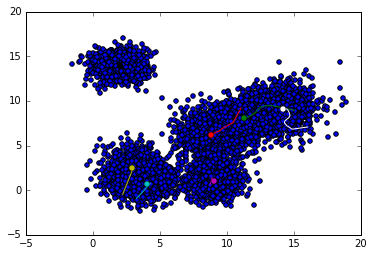

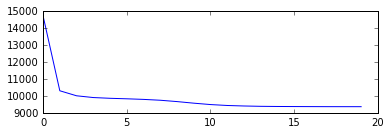

In [9]:
traces, dists = kmeans.kmeans("kmedians")

fig = plt.figure()
centers_trace = fig.add_subplot(111)
centers_trace.scatter(kmeans.dataset.data[:, 0], kmeans.dataset.data[:, 1])

cycol = itl.cycle('grcmykw').next

assert kmeans.dataset.cluster_num < 8, 'number of color is not enough for number of clusters'

for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[:, i, 0], traces[:, i, 1], cycol()) 

cycol = itl.cycle('grcmykw').next
for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[-1, i, 0], traces[-1, i, 1], cycol() + 'o') 

fig = plt.figure()
dists_trace = fig.add_subplot(212)
dists_trace.plot(dists)
plt.show()

### Run KMeans++


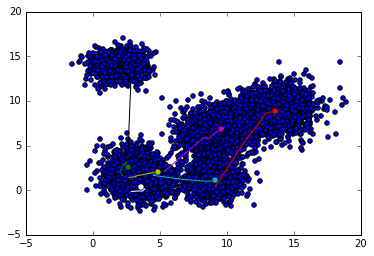

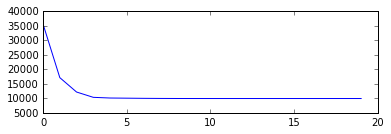

In [11]:
traces, dists = kmeans.kmeans("kmeans++")

fig = plt.figure()
centers_trace = fig.add_subplot(111)
centers_trace.scatter(kmeans.dataset.data[:, 0], kmeans.dataset.data[:, 1])

cycol = itl.cycle('grcmykw').next

assert kmeans.dataset.cluster_num < 8, 'number of color is not enough for number of clusters'

for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[:, i, 0], traces[:, i, 1], cycol()) 

cycol = itl.cycle('grcmykw').next
for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[-1, i, 0], traces[-1, i, 1], cycol() + 'o') 

fig = plt.figure()
dists_trace = fig.add_subplot(212)
dists_trace.plot(dists)
plt.show()

### Run KMedoids

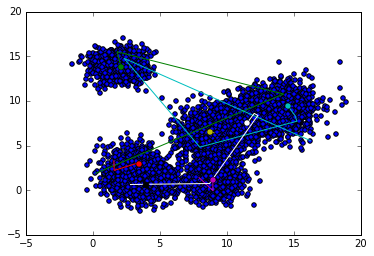

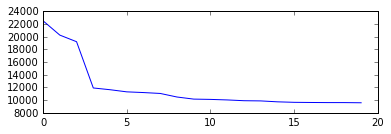

In [12]:
traces, dists = kmeans.kmeans("kmedoids")

fig = plt.figure()
centers_trace = fig.add_subplot(111)
centers_trace.scatter(kmeans.dataset.data[:, 0], kmeans.dataset.data[:, 1])

cycol = itl.cycle('grcmykw').next

assert kmeans.dataset.cluster_num < 8, 'number of color is not enough for number of clusters'

for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[:, i, 0], traces[:, i, 1], cycol()) 

cycol = itl.cycle('grcmykw').next
for i in xrange(kmeans.dataset.cluster_num):
    centers_trace.plot(traces[-1, i, 0], traces[-1, i, 1], cycol() + 'o') 

fig = plt.figure()
dists_trace = fig.add_subplot(212)
dists_trace.plot(dists)
plt.show()

Training...

...ready!


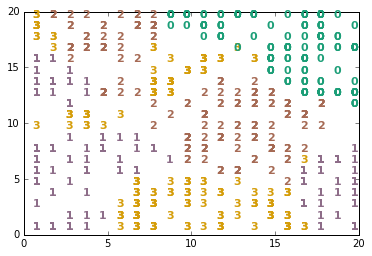

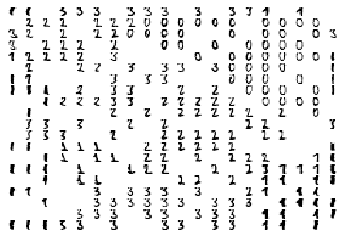

In [19]:
# load the digits dataset from scikit-learn
# 901 samples, about 180 samples per class
# the digits represented 0,1,2,3,4
#%matplotlib inline
from sklearn import datasets
from scipy import ndimage

digits = datasets.load_digits(n_class=4)
data = digits.data # matrix where each row is a vector that represent a digit.
num = digits.target # num[i] is the digit represented by data[i]

# training the som
from minisom import MiniSom
som = MiniSom(20,20,64,sigma=.8,learning_rate=0.5)
print("Training...")
som.train_random(data,5500) # random training
print("\n...ready!")

# plotting the results
from pylab import text,show,cm,axis,figure,subplot,imshow,zeros
wmap = {}
figure(1)
im = 0
for x,t in zip(data,num): # scatterplot
	w = som.winner(x)
	wmap[w] = im
	text(w[0]+.5, w[1]+.5, str(t), color=cm.Dark2(t / 4.), fontdict={'weight': 'bold', 'size': 11})
	im = im + 1
axis([0,som.weights.shape[0],0,som.weights.shape[1]])

def cwrotate90(cnt):
    return (((cnt+1)%20)*20 - ((cnt+1)/20)) %400

def cwrotate270(cnt):
    return rotate90(rotate90(rotate90(cnt)))

figure(2,facecolor='white')
cnt = 0
for i in range(20): # images mosaic
	for j in range(20):
		subplot(20,20, cwrotate270(cnt), frameon=False, xticks=[], yticks=[])
		if (i,j) in wmap:
			imshow(digits.images[wmap[(i,j)]], cmap='Greys',  interpolation='nearest')
		else:
			imshow(zeros((8,8)), cmap='Greys')
		cnt = cnt + 1

show() # show the figure